In [21]:
# import libraries
import pandas as pd
import sqlite3
from scipy.stats import stats
from scipy.stats import binom_test

# Warby Parker Usage funnel and A/B Test

Warby Parker is an American eyewear brand which aims to deliver sleek, designer eyewear for an affordable price, whilst being a socially conscious business.

For every pair of glasses sold (both corrective and sunglasses), a pair is distributed to someone in need.

The team at Warby Parker would like to gather some information about their customers:

* First, they have created and distributed a survey in which they ask five questions designed to deepen their understanding of their customer base's preferences

* Second, they have come up with an A/B test: they would like to see the effect of sending two different quantities of glasses to customers to try on at home impacts sales. Some customers are sent three pairs, and some are sent five pairs. Which quanitity is more likely to lead to the sale of glasses?

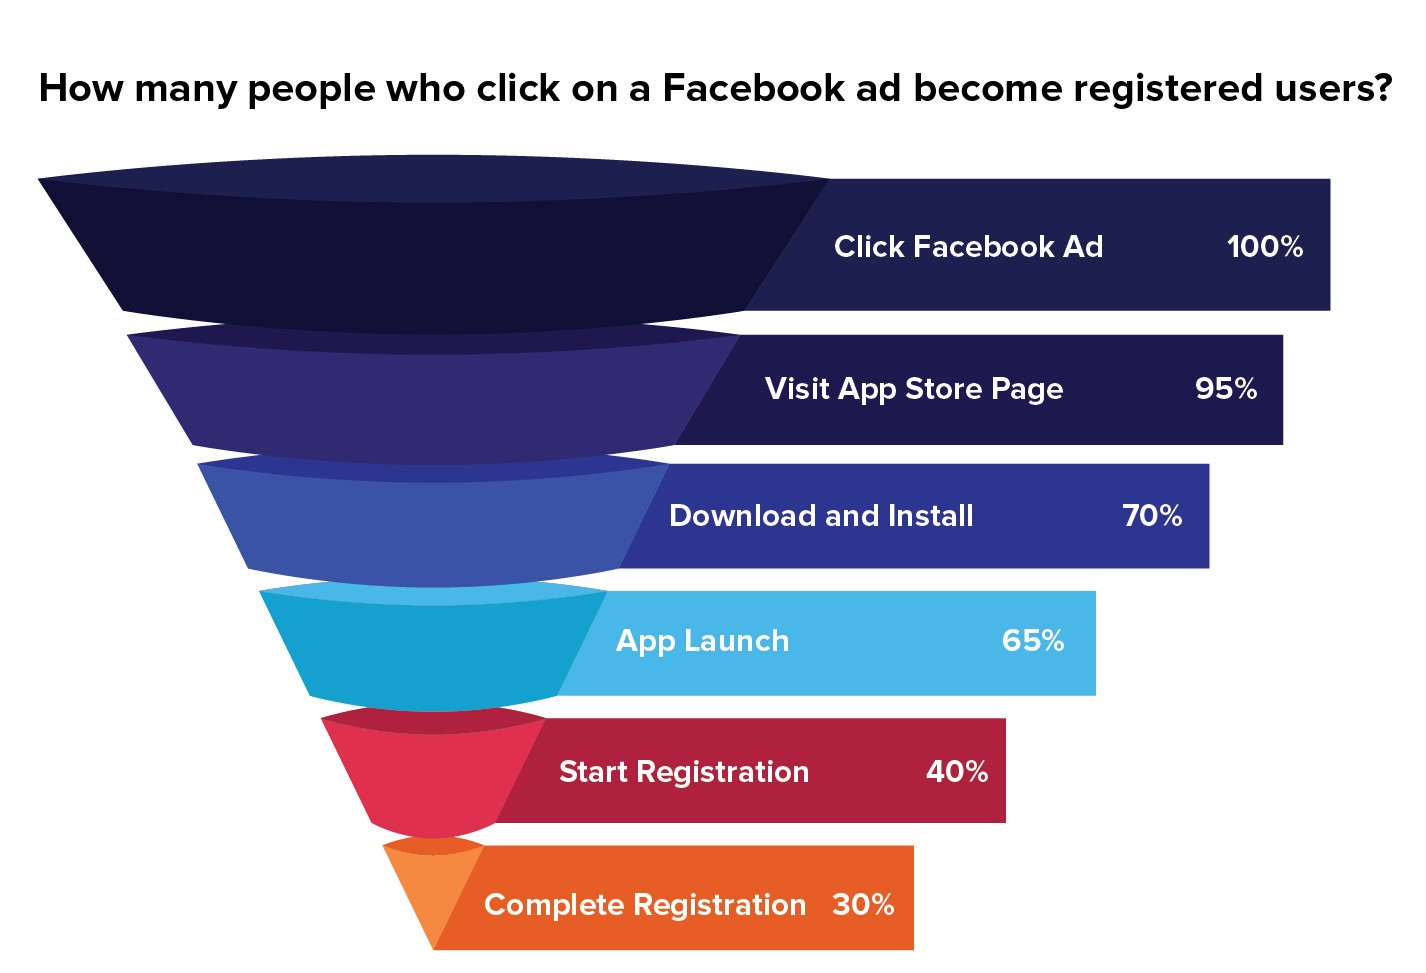

Above is an example of an e-commerce usage funnel (image courtesy of clevertap.com)

# Survey

A Survey was sent out to 500 Warby Parker customers asking five questions:
* What are you looking for?
* What's your fit?
* Which shapes do you like?
* Which colours do you like?
* When was your last eye exam?

The aim is to examine how many customers progressed through all of the questions, and if drop-off is especially high for a particular question

In [2]:
# read in the survey data
survey_df = pd.read_csv('survey.csv')

In [3]:
# create a database and database connection object
conn = sqlite3.connect('warby_parker_funnels.db')

In [4]:
# convert the pandas dataframe to SQL and add it to the new database
survey_db = survey_df.to_sql('survey', conn)

In [5]:
%load_ext sql

In [6]:
%sql sqlite:///warby_parker_funnels.db

'Connected: @warby_parker_funnels.db'

In [7]:
%%sql
SELECT *
FROM survey
LIMIT 5

 * sqlite:///warby_parker_funnels.db
Done.


index,Question,User_id,Response
0,1. What are you looking for?,005e7f99-d48c-4fce-b605-10506c85aaf7,Women's Styles
1,2. What's your fit?,005e7f99-d48c-4fce-b605-10506c85aaf7,Medium
2,3. How old are you?,00a556ed-f13e-4c67-8704-27e3573684cd,Round
3,4. Which colors do you like?,00a556ed-f13e-4c67-8704-27e3573684cd,Two-Tone
4,1. What are you looking for?,00a556ed-f13e-4c67-8704-27e3573684cd,I'm not sure. Let's skip it.


In [8]:
%%sql
SELECT Question, COUNT(Response)
FROM survey
GROUP BY Question

 * sqlite:///warby_parker_funnels.db
Done.


Question,COUNT(Response)
1. What are you looking for?,500
2. What's your fit?,475
3. How old are you?,380
4. Which colors do you like?,361
5. When was your last eye exam?,270


We can use the count of each response to find the completion rate of the funnel in excel.

We can also highlight the drop-off going question-by question:

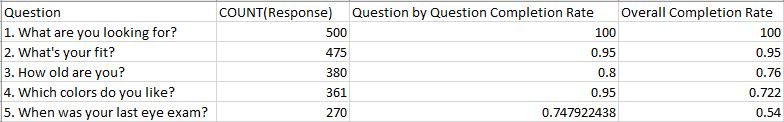

As can be seen in the table above, only around half of the respondents are fully completing the survey.

Also, the largest drop-off in respondents is seen going from the fourth to the last question.

## Two interesting insights

* Largest drop-off suggests that customers either don't remember when they had their last exam and the question is too much of a bother for them to answer, or possibly they are overdue an eye exam and don't want to share that information
* The second largest drop-off is for the "how old are you?" question - suggesting some customers don't want to reveal their age.

# At-home try on: A/B Test

Three datasets are created
* `Quiz` - customers are sent a quiz which asks for their favourite `fit`, `shape`, and `colour`
* `Purchase` - a table containing purchases from user IDs and data about the glasses being purchased
* `home_try_on` - a table containing `user ID`s, the number of pairs being sent, and the customer's address

These tables will be joined on `user_id` and investigated to find out which A/B variant - 3 pairs or 5 pairs - results in more purchases

In [9]:
quiz_df = pd.read_csv('quiz.csv')
purchase_df = pd.read_csv('purchase.csv')
hto_df = pd.read_csv('home_try_on.csv')

In [10]:
quiz_db = quiz_df.to_sql('quiz', conn)

In [11]:
%%sql
SELECT *
FROM quiz
LIMIT 10

 * sqlite:///warby_parker_funnels.db
Done.


index,User_id,Style,Fit,Shape,Colour
0,4e8118dc-bb3d-49bf-85fc-cca8d83232ac,Women's Styles,Medium,Rectangular,Tortoise
1,291f1cca-e507-48be-b063-002b14906468,Women's Styles,Narrow,Round,Black
2,75122300-0736-4087-b6d8-c0c5373a1a04,Women's Styles,Wide,Rectangular,Two-Tone
3,75bc6ebd-40cd-4e1d-a301-27ddd93b12e2,Women's Styles,Narrow,Square,Two-Tone
4,ce965c4d-7a2b-4db6-9847-601747fa7812,Women's Styles,Wide,Rectangular,Black
5,28867d12-27a6-4e6a-a5fb-8bb5440117ae,Women's Styles,Narrow,Rectangular,Black
6,5a7a7e13-fbcf-46e4-9093-79799649d6c5,Women's Styles,Wide,Rectangular,Tortoise
7,0143cb8b-bb81-4916-9750-ce956c9f9bd9,Women's Styles,Wide,Rectangular,Two-Tone
8,a4ccc1b3-cbb6-449c-b7a5-03af42c97433,Women's Styles,I'm not sure. Let's skip it.,Square,Tortoise
9,b1dded76-cd60-4222-82cb-f6d464104298,Women's Styles,Narrow,Rectangular,Crystal


In [12]:
purchase_db = purchase_df.to_sql('purchase', conn)

In [13]:
%%sql
SELECT *
FROM purchase
LIMIT 10

 * sqlite:///warby_parker_funnels.db
Done.


index,User_id,Product_id,Style,Model_name,Colour,Price
0,00a9dd17-36c8-430c-9d76-df49d4197dcf,8,Women's Styles,Lucy,Jet Black,150
1,00e15fe0-c86f-4818-9c63-3422211baa97,7,Women's Styles,Lucy,Elderflower Crystal,150
2,017506f7-aba1-4b9d-8b7b-f4426e71b8ca,4,Men's Styles,Dawes,Jet Black,150
3,0176bfb3-9c51-4b1c-b593-87edab3c54cb,10,Women's Styles,Eugene Narrow,Rosewood Tortoise,95
4,01fdf106-f73c-4d3f-a036-2f3e2ab1ce06,8,Women's Styles,Lucy,Jet Black,150
5,021901a5-74ee-482d-9f03-0089d17ff7d6,3,Men's Styles,Dawes,Driftwood Fade,150
6,026e11d9-926c-4206-af7c-273e3ee6ad7f,2,Men's Styles,Brady,Sea Glass Gray,95
7,028b47b0-e075-4b2c-bcf3-f963d8089449,10,Women's Styles,Eugene Narrow,Rosewood Tortoise,95
8,029e417e-a0b5-4ec7-9190-a852016619d9,5,Men's Styles,Monocle,Endangered Tortoise,50
9,02bd0f5a-3f04-4902-b005-82188b07785f,7,Women's Styles,Lucy,Elderflower Crystal,150


In [14]:
hto_db = hto_df.to_sql('home_try_on', conn)

In [15]:
%%sql
SELECT *
FROM home_try_on
LIMIT 10

 * sqlite:///warby_parker_funnels.db
Done.


index,User_id,Numer_of_pairs,Address
0,d8addd87-3217-4429-9a01-d56d68111da7,5 pairs,145 New York 9a
1,f52b07c8-abe4-4f4a-9d39-ba9fc9a184cc,5 pairs,383 Madison Ave
2,8ba0d2d5-1a31-403e-9fa5-79540f8477f9,5 pairs,287 Pell St
3,4e71850e-8bbf-4e6b-accc-49a7bb46c586,3 pairs,347 Madison Square N
4,3bc8f97f-2336-4dab-bd86-e391609dab97,5 pairs,182 Cornelia St
5,4c10e298-53c8-4009-adda-bbcaecb7e8b6,5 pairs,312 Frawley Cir
6,5a3ee321-517d-4a21-a351-d6815ab2edd5,5 pairs,301 Fred Douglass Cir
7,4d895ccf-4877-4f13-8183-13d7d0a20a47,3 pairs,77 Margaret Corbin Dr
8,39e8a811-75b9-4dc3-bdff-c92b6db0431d,3 pairs,482 Coenties Slip
9,9d2656a0-d066-4b42-bce1-77825f34ded9,5 pairs,364 De Peyster St


In [16]:
%%sql
WITH funnel AS (
    SELECT quiz.User_id,
        home_try_on.User_id IS NOT NULL AS is_home_try_on,
        home_try_on.Numer_of_pairs,
        purchase.User_id IS NOT NULL AS is_purchase
    FROM quiz
    LEFT JOIN home_try_on
        ON home_try_on.User_id = quiz.User_id
    LEFT JOIN purchase
        ON purchase.User_id = quiz.User_id)
SELECT COUNT(User_id), SUM(is_home_try_on), SUM(is_purchase)
FROM funnel
LIMIT 10

 * sqlite:///warby_parker_funnels.db
Done.


COUNT(User_id),SUM(is_home_try_on),SUM(is_purchase)
1000,750,495


Looking at the above table we can see that:
* 1000 people were included in the A/B test
* 750 people were sent glasses to try on at home
* 66% of the people who were sent glasses went on to buy glasses

In [17]:
%%sql
WITH funnel AS (
    SELECT q.User_id,
        h.User_id IS NOT NULL as 'is_home_try_on',
        h.numer_of_pairs AS 'AB_variant',
        p.User_id IS NOT NULL AS 'is_purchase'
    FROM quiz q
    LEFT JOIN home_try_on h
        ON h.User_id = q.User_id
    LEFT JOIN purchase p
        ON p.User_id = q.User_id
    )
    SELECT AB_variant,
        SUM(CASE WHEN is_home_try_on = 1
           THEN 1
           ELSE 0
           END) 'home_trial',
        SUM(CASE WHEN is_purchase = 1
           THEN 1
           ELSE 0
           END) 'purchase'
FROM funnel
GROUP BY AB_variant

 * sqlite:///warby_parker_funnels.db
Done.


AB_variant,home_trial,purchase
None,0,0
3 pairs,379,201
5 pairs,371,294


Getting rid of the top line:

In [18]:
%%sql
WITH funnel AS (
    SELECT q.User_id,
        h.User_id IS NOT NULL as 'is_home_try_on',
        h.numer_of_pairs AS 'AB_variant',
        p.User_id IS NOT NULL AS 'is_purchase'
    FROM quiz q
    LEFT JOIN home_try_on h
        ON h.User_id = q.User_id
    LEFT JOIN purchase p
        ON p.User_id = q.User_id
    )
    SELECT AB_variant,
        SUM(CASE WHEN is_home_try_on = 1
           THEN 1
           ELSE 0
           END) 'home_trial',
        SUM(CASE WHEN is_purchase = 1
           THEN 1
           ELSE 0
           END) 'purchase'
FROM funnel
GROUP BY AB_variant
HAVING home_trial>0

 * sqlite:///warby_parker_funnels.db
Done.


AB_variant,home_trial,purchase
3 pairs,379,201
5 pairs,371,294


# The Results

We can see that the number of people who received each quantity of glasses was almost the same, which helps to act as a control.
However, there is a significant increase in the number of purchases amongst the group who received 5 pairs of glasses
* 53% of people receiving 3 pairs of glasses moved on to make a purchase
* 79% of people receiving 5 pairs of glasses moved on to make a purchase

This is an increase in sales of 26%

# Testing the Results

If we begin with the **null hypothesis** that sending pairs of glasses has no effect on customers buying more glasses, and that sending glasses will result in a random number of people going on to complete a purchase then:

1. Assume that randomness means that 50% of the 379/374 people would otherwise continue on to make a purchase (p=0.5)
2. We can run a binomial test on the results to find the probability of finding results at least as extreme under the null hypothesis (the **p-value**)

The result from the `3 pair` variant test will be statistically significant as approximately 50% of respondents went on to make a purchase, but we will include it in the analysis for completeness.

The results for the `5 pair` trial will, however, be statistically significant.

In [28]:
# for the 3 pair variant
three_pair_binom = binom_test(201, n=379, p=0.5)
print("p-value is: " +str(three_pair_binom))

p-value is: 0.25842053033866347


In [29]:
# for the 5 pair variant
five_pair_binom = binom_test(294, n=371, p=0.5)
print("p-value is: " + str(five_pair_binom))

p-value is: 5.506820866624332e-31


# Recommendations

## Recommendations for the usage funnel

Consultation with the survey makers would be necessary to find out what the exact aim of the survey is. Is it necessary to know they customer's age? And do Warby Parker offer eye exams? If not, it may be best to not include the question about an eye exam and focus more on a question related to glasses or style.


## Recommendations for the A/B Test
1. So, the p-value for the results seen with the 5 pair variant is extremely small, far smaller than the 0.05 threshold that would qualify it as being significant.

2. With this result, I would recommend that Warby Parker move on to a larger-scale trial where five pairs of glasses are sent to a larger number of customers for them to try on at home.

3. As the sample size for the trial increases, it will become increasingly clear whether this is having a significant and sustained impact on sales.

4. Continuing with a trial will also allow for any negative consequences of sending multiple pairs of glasses to customers emerge. For example, issues with customers not returning glasses, glasses being lost, or supply issues coming about due to sending such large numbers of glasses to customers.